In [1]:

from typing import Dict, List

import numpy as np
import numpy.typing as npt
import pandas as pd
import tensorflow as tf
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, models, losses

from spectrogram import Spectrogram, split_spectrogram
from spectrum_painting import take_frequencies, downsample_spectrogram, augment_spectrogram, paint_spectrogram, \
    digitize_spectrogram

In [2]:
def convert_complex_numbers(frame: pd.DataFrame) -> pd.DataFrame:
    """
    Convert complex numbers strings where 'i' (Math convention) is used to use 'j' (Engineering convention) instead
    and convert it to numpy complex number type.
    :param frame: A Pandas dataframe
    :return: A data frame containing numpy complex numbers.
    """
    return frame.map(lambda row: np.csingle(row.replace("i", "j")))[0]


# Read the data where b = Bluetooth, w = WiFi, z = Zigbee. So the frame
# called 'zb' means it is the spectrogram containing Zigbee and Bluetooth
# signals.
data_frames: Dict[str, pd.DataFrame] = {
    "b": pd.read_csv("data/csv/B_SNR30.csv", sep=",", header=None, dtype=str),
    "bw": pd.read_csv("data/csv/BW_SNR30.csv", sep=",", header=None, dtype=str),
    "w": pd.read_csv("data/csv/W_SNR30.csv", sep=",", header=None, dtype=str),
    "z": pd.read_csv("data/csv/Z_SNR30.csv", sep=",", header=None, dtype=str),
    "zb": pd.read_csv("data/csv/ZB_SNR30.csv", sep=",", header=None, dtype=str),
    "zw": pd.read_csv("data/csv/ZW_SNR30.csv", sep=",", header=None, dtype=str),
    "zbw": pd.read_csv("data/csv/ZBW_SNR30.csv", sep=",", header=None, dtype=str)
}

# Convert complex number notation
data_frames = {key: convert_complex_numbers(frame) for key, frame in data_frames.items()}

In [3]:
def plot_spectrogram(spectrogram: Spectrogram):
    plt.pcolormesh(spectrogram.f, spectrogram.t, spectrogram.values.T, shading="nearest")
    plt.xlabel("Frequency (Hz)")
    plt.ylabel("Time (s)")
    plt.title("Spectrogram")
    plt.colorbar(label="Magnitude (dB)")
    plt.show()

/Users/sethd/Desktop/spectrum-painting/src/spectrum_painting.py:86: RuntimeWarning: divide by zero encountered in scalar divide
  scale: float = color_depth / max_value
/Users/sethd/Desktop/spectrum-painting/src/spectrum_painting.py:88: RuntimeWarning: invalid value encountered in multiply
  scaled_spectrogram = spectrogram * scale


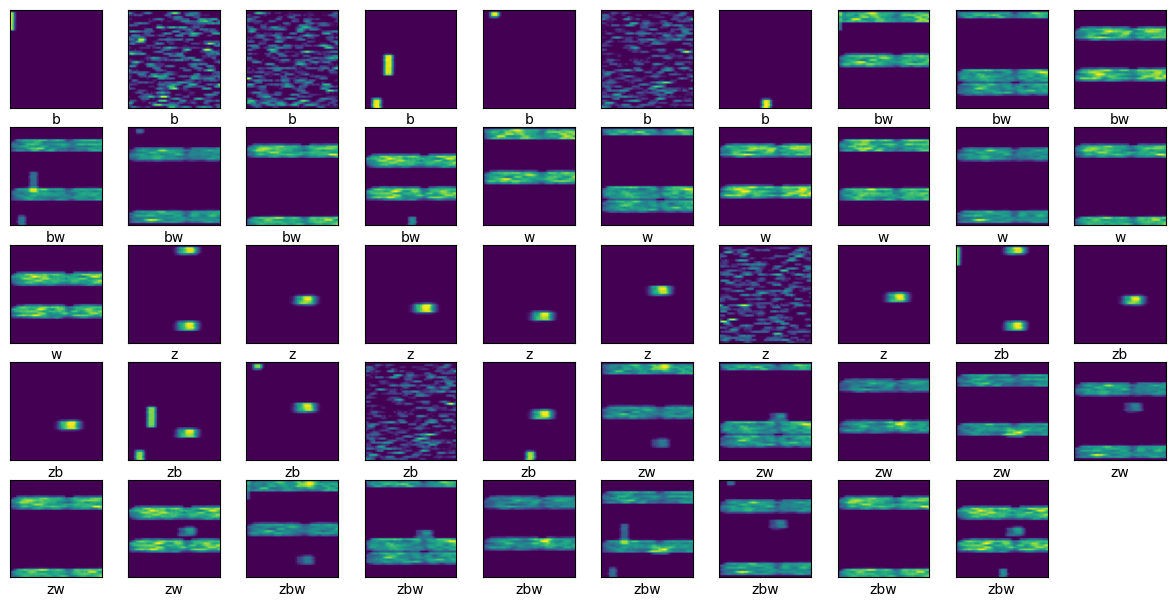

Number of training images: 34


In [4]:
from src.spectrogram import create_spectrogram

# Sampling frequency
fs = 20000000  # 20MHz

spectrograms: Dict[str, Spectrogram] = {key: create_spectrogram(frame, fs) for key, frame in data_frames.items()}

downsample_resolution = 48

K = 3
L = 4
D = 1

# a depth of 256 means each pixel is 1 byte because there is only one color channel.
color_depth = 256

# Training images should be 2D *byte* arrays to save space and the color depth is only 256 which means
# any bigger than a byte is just wasted memory.
x_train_augmented: List[npt.NDArray[np.uint8]] = []
x_train_painted: List[npt.NDArray[np.uint8]] = []
label_names: [str] = []
labels: [np.uint8] = []

for (class_index, (label, spec)) in enumerate(spectrograms.items()):
    label_names.append(label)

    middle: int = len(spec.values) // 2
    start_freq: int = middle - 30
    end_freq: int = middle + 30

    spec = take_frequencies(spec, start_freq, end_freq)

    slices = split_spectrogram(spec, duration=1000)

    downsampled_slices = [downsample_spectrogram(s.values, downsample_resolution) for s in slices]
    augmented_slices = [augment_spectrogram(s, K, L, D) for s in downsampled_slices]

    for s in augmented_slices:
        x_train_augmented.append(digitize_spectrogram(s, color_depth).astype(dtype=np.uint8))

    painted_slices = [paint_spectrogram(original, augmented) for (original, augmented) in
                      list(zip(downsampled_slices, augmented_slices))]

    for s in painted_slices:
        x_train_painted.append(digitize_spectrogram(s, color_depth).astype(dtype=np.uint8))

    for i in range(len(slices)):
        labels.append(class_index)

plt.figure(figsize=(15, 15))
for i in range(len(x_train_augmented)):
    image = x_train_augmented[i]
    plt.subplot(10, 10, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(image)
    plt.xlabel(label_names[labels[i]])
plt.show()

x_train_combined = np.stack((x_train_augmented, x_train_painted), axis=3)

x_train, x_test, y_train, y_test = train_test_split(x_train_combined, labels, test_size=0.3, random_state=42)

# for tensorflow it must be uint8 and not a Python int.
y_train = np.array(y_train, dtype=np.uint8)
y_test = np.array(y_test, dtype=np.uint8)

x_train_augmented = x_train[:, :, :, 0]
x_test_augmented = x_test[:, :, :, 0]

x_train_painted = x_train[:, :, :, 1]
x_test_painted = x_test[:, :, :, 1]

print(f"Number of training images: {len(x_train)}")


(48, 45, 1)
Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_11 (InputLayer)       [(None, 48, 45, 1)]          0         []                            
                                                                                                  
 input_12 (InputLayer)       [(None, 48, 45, 1)]          0         []                            
                                                                                                  
 conv2d_26 (Conv2D)          (None, 42, 39, 8)            400       ['input_11[0][0]']            
                                                                                                  
 conv2d_29 (Conv2D)          (None, 42, 39, 8)            400       ['input_12[0][0]']            
                                                                                

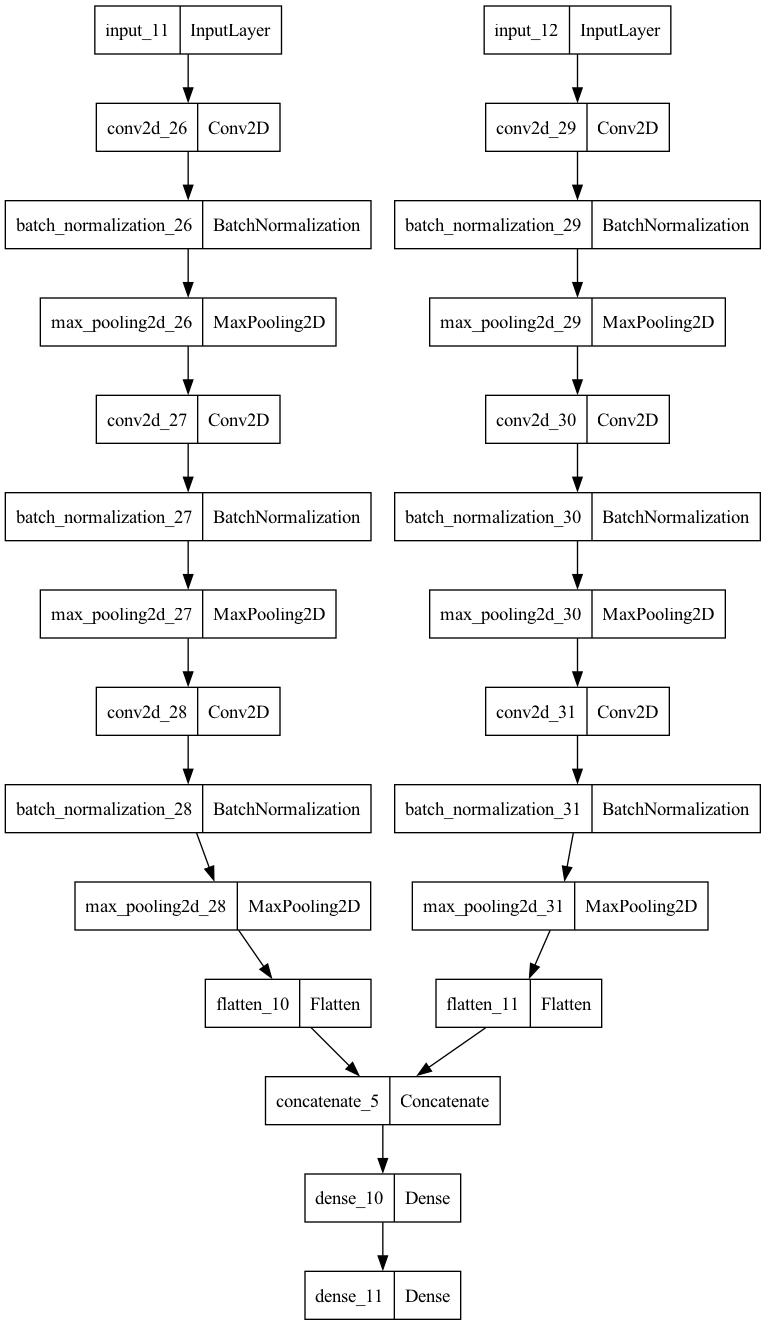

In [21]:
image_shape = x_train_augmented[0].shape
# The input shape to the CNN is the height, width and number of color channels. The spectrograms
# only have one color channel.
input_shape = (image_shape[0], image_shape[1], 1)
print(input_shape)

augmented_input = layers.Input(shape=input_shape)
augmented_model = layers.Conv2D(filters=8, kernel_size=(7, 7), activation='relu')(augmented_input)
augmented_model = layers.BatchNormalization()(augmented_model)
augmented_model = layers.MaxPooling2D((2, 2))(augmented_model)

augmented_model = layers.Conv2D(filters=8, kernel_size=(5, 5), activation='relu')(augmented_model)
augmented_model = layers.BatchNormalization()(augmented_model)
augmented_model = layers.MaxPooling2D((2, 2))(augmented_model)

augmented_model = layers.Conv2D(filters=8, kernel_size=(3, 3), activation='relu')(augmented_model)
augmented_model = layers.BatchNormalization()(augmented_model)
augmented_model = layers.MaxPooling2D((2, 2))(augmented_model)

# Flatten the 3D image output to 1 dimension
augmented_model = layers.Flatten()(augmented_model)
painted_input = layers.Input(shape=input_shape)
painted_model = layers.Conv2D(filters=8, kernel_size=(7, 7), activation='relu', input_shape=input_shape)(painted_input)
painted_model = layers.BatchNormalization()(painted_model)
painted_model = layers.MaxPooling2D((2, 2))(painted_model)

painted_model = layers.Conv2D(filters=8, kernel_size=(5, 5), activation='relu')(painted_model)
painted_model = layers.BatchNormalization()(painted_model)
painted_model = layers.MaxPooling2D((2, 2))(painted_model)

painted_model = layers.Conv2D(filters=8, kernel_size=(3, 3), activation='relu')(painted_model)
painted_model = layers.BatchNormalization()(painted_model)
painted_model = layers.MaxPooling2D((2, 2))(painted_model)

# Flatten the 3D image output to 1 dimension
painted_model = layers.Flatten()(painted_model)

output = layers.Concatenate()([augmented_model, painted_model])
output = layers.Dense(64, activation='relu')(output)

label_count = len(spectrograms)
output = layers.Dense(label_count)(output)

model = models.Model(inputs=[augmented_input, painted_input], outputs=[output])

model.summary()
tf.keras.utils.plot_model(model)

Epoch 1/10
2/2 [==============================] - 0s 104ms/step - loss: 2.7427 - accuracy: 0.1765 - val_loss: 10.0592 - val_accuracy: 0.1333
Epoch 2/10
2/2 [==============================] - 0s 15ms/step - loss: 2.0984 - accuracy: 0.2353 - val_loss: 8.1868 - val_accuracy: 0.0667
Epoch 3/10
2/2 [==============================] - 0s 17ms/step - loss: 1.7650 - accuracy: 0.2647 - val_loss: 7.0373 - val_accuracy: 0.0667
Epoch 4/10
2/2 [==============================] - 0s 18ms/step - loss: 1.5467 - accuracy: 0.4412 - val_loss: 6.6062 - val_accuracy: 0.0667
Epoch 5/10
2/2 [==============================] - 0s 15ms/step - loss: 1.4228 - accuracy: 0.4412 - val_loss: 6.2292 - val_accuracy: 0.1333
Epoch 6/10
2/2 [==============================] - 0s 15ms/step - loss: 1.3822 - accuracy: 0.5294 - val_loss: 6.0414 - val_accuracy: 0.0667
Epoch 7/10
2/2 [==============================] - 0s 15ms/step - loss: 1.2692 - accuracy: 0.5294 - val_loss: 5.8333 - val_accuracy: 0.1333
Epoch 8/10
2/2 [=========

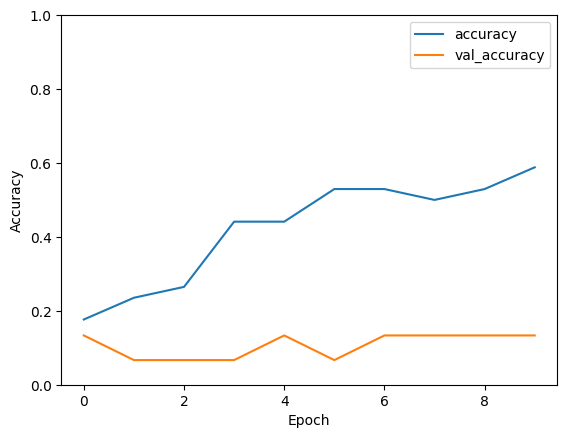

In [22]:
model.compile(optimizer='adam',
              loss=losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

# convert ints to the type of int that can be used in a Tensor
history = model.fit(x=[x_train_augmented, x_train_painted], y=y_train, epochs=10,
                    validation_data=([x_test_augmented, x_test_painted], y_test))

plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='upper right')

In [23]:
final_loss, final_acc = model.evaluate([x_test_augmented, x_test_painted], y_test, verbose=1)
print("Final loss: {0:.6f}, final accuracy: {1:.6f}".format(final_loss, final_acc))

1/1 [==============================] - 0s 12ms/step - loss: 5.2888 - accuracy: 0.1333
Final loss: 5.288850, final accuracy: 0.133333


In [9]:
output_file = "output/spectrum-painting-model.keras"

tf.saved_model.save(model, "output/")
model.save(output_file)

INFO:tensorflow:Assets written to: output/assets


INFO:tensorflow:Assets written to: output/assets


In [27]:
# Convert the model
# This requires TensorFlow 2.15.0 for it to work. See https://github.com/tensorflow/tensorflow/issues/63987
converter = tf.lite.TFLiteConverter.from_keras_model(model)

# TensorFlow Lite Micro does not support Hybrid models so disable the default optimizations for now
# until full quantization can be done.
# converter.optimizations = [tf.lite.Optimize.DEFAULT]

print("Converting...")
tflite_model = converter.convert()
print(f"Done. Model size = {len(tflite_model) // 1000} KB")

# Save the model.
with open('output/spectrum-painting-model.tflite', 'wb') as f:
    f.write(tflite_model)


Converting...
INFO:tensorflow:Assets written to: /var/folders/81/3wz7wxg90f3df6qvy1xbf71m0000gn/T/tmpz0v0lgtg/assets


INFO:tensorflow:Assets written to: /var/folders/81/3wz7wxg90f3df6qvy1xbf71m0000gn/T/tmpz0v0lgtg/assets


Done. Model size = 57 KB


2024-05-15 12:41:45.404290: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2024-05-15 12:41:45.404309: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:381] Ignored drop_control_dependency.
2024-05-15 12:41:45.404446: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /var/folders/81/3wz7wxg90f3df6qvy1xbf71m0000gn/T/tmpz0v0lgtg
2024-05-15 12:41:45.406336: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2024-05-15 12:41:45.406343: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: /var/folders/81/3wz7wxg90f3df6qvy1xbf71m0000gn/T/tmpz0v0lgtg
2024-05-15 12:41:45.411989: I tensorflow/cc/saved_model/loader.cc:233] Restoring SavedModel bundle.
2024-05-15 12:41:45.487176: I tensorflow/cc/saved_model/loader.cc:217] Running initialization op on SavedModel bundle at path: /var/folders/81/3wz7wxg90f3df6qvy1xbf71m0000gn/T/tmpz0v0lgtg
2024-05-

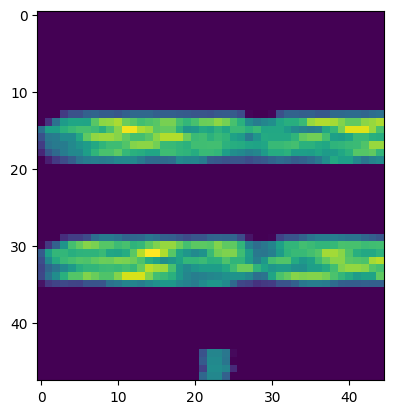

1/1 [==============================] - 0s 66ms/step
bw


In [11]:
# Predict with full Tensorflow
test_img_augmented = x_test_augmented[0]
test_img_painted = x_test_painted[0]

plt.imshow(test_img_augmented)
plt.show()

test_img_augmented.shape += (1,)
test_img_augmented = (np.expand_dims(test_img_augmented, 0))

test_img_painted.shape += (1,)
test_img_painted = (np.expand_dims(test_img_painted, 0))

predictions_single = model.predict(x=[(test_img_augmented, test_img_painted)])
prediction_index = np.argmax(predictions_single[0])
print(label_names[prediction_index])


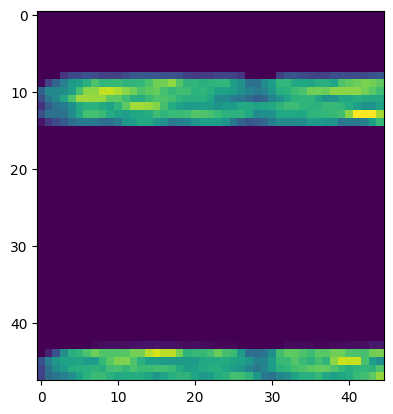

[ 0.02260935  1.1875564   0.15268683  0.3322097  -2.825703   -0.6873374
 -3.0698123 ]
bw


In [25]:
# Test with Tensorflow Lite

interpreter = tf.lite.Interpreter(model_content=tflite_model)
interpreter.allocate_tensors()

input_details = interpreter.get_input_details()[0]
output_details = interpreter.get_output_details()[0]

test_img_augmented = x_test_augmented[2]
test_img_painted = x_test_painted[2]

plt.imshow(test_img_augmented)
plt.show()

test_img_augmented.shape += (1,)
test_img_augmented = (np.expand_dims(test_img_augmented, 0))
test_img_augmented = test_img_augmented.astype(np.float32)

test_img_painted.shape += (1,)
test_img_painted = (np.expand_dims(test_img_painted, 0))
test_img_painted = test_img_painted.astype(np.float32)

interpreter.set_tensor(0, test_img_augmented)
interpreter.set_tensor(1, test_img_painted)

interpreter.invoke()

prediction = interpreter.get_tensor(output_details["index"])[0]
print(prediction)
prediction_index = np.argmax(prediction)
print(label_names[prediction_index])

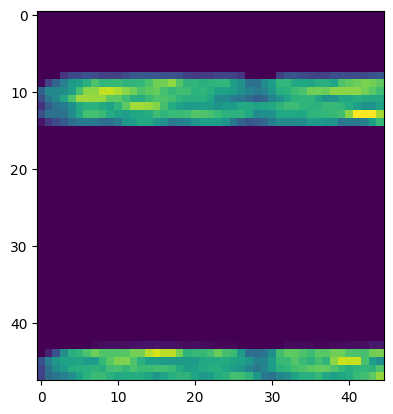

In [26]:
test_img_augmented = x_test_augmented[2]
test_img_painted = x_test_painted[2]

plt.imshow(test_img_augmented)
plt.show()

test_img_augmented.shape += (1,)
test_img_augmented = (np.expand_dims(test_img_augmented, 0))
test_img_augmented = test_img_augmented.astype(np.float32)

test_img_painted.shape += (1,)
test_img_painted = (np.expand_dims(test_img_painted, 0))
test_img_painted = test_img_painted.astype(np.float32)

with open('output/augmented_image.bytes', 'wb') as f:
    f.write(test_img_augmented.tobytes())

with open('output/painted_image.bytes', 'wb') as f:
    f.write(test_img_painted.tobytes())

# with serial.Serial("/dev/cu.usbmodem2101", timeout=5) as ser:
#     ser.write(augmented_bytes)
#     ser.write(painted_bytes)
#     print(ser.readline())
#     print(ser.readline())
#     print(ser.readline())
#     print(ser.readline())
#     print(ser.readline())
